# Retail - PGP
## Project 1 

## DESCRIPTION

Problem Statement
It is a critical requirement for business to understand the value derived from a customer. RFM is a method used for analyzing customer value.
Customer segmentation is the practice of segregating the customer base into groups of individuals based on some common characteristics such as age, gender, interests, and spending habits
Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value).
Dataset Description
This is a transnational data set which contains all the transactions that occurred between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique and all-occasion gifts.

## IMPORTS

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings(action="ignore")
import re
import scipy as sp
from operator import attrgetter
import datetime as dt

## Loading the data

In [2]:
Online_Retail = pd.read_excel('Online Retail.xlsx',dtype={'CustomerID': str,'InvoiceID': str},parse_dates=['InvoiceDate'], 
                   infer_datetime_format=True)

In [3]:
Online_Retail.head(6)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom


## Project Task: Week 1
### Data Cleaning:

### 1)Perform a preliminary data inspection and data cleaning.

### a. Check for missing data and formulate an apt strategy to treat them.

In [4]:
Online_Retail.shape

(541909, 8)

In [5]:
Online_Retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
Online_Retail.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
Online_Retail.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [8]:
Online_Retail.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

### b. Remove duplicate data records.

In [9]:
Online_Retail.dropna(subset=['CustomerID'], inplace=True)

In [10]:
Online_Retail.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


In [11]:
Online_Retail[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

,CustomerID,InvoiceNo,InvoiceDate
0,17850,536365,2010-12-01 08:26:00
7,17850,536366,2010-12-01 08:28:00
9,13047,536367,2010-12-01 08:34:00
21,13047,536368,2010-12-01 08:34:00
25,13047,536369,2010-12-01 08:35:00
...,...,...,...
541865,13777,581583,2011-12-09 12:23:00
541867,13777,581584,2011-12-09 12:25:00
541869,15804,581585,2011-12-09 12:31:00
541890,13113,581586,2011-12-09 12:49:00


### c. Perform descriptive analytics on the given data.

In [12]:
n_orders = Online_Retail.groupby(['CustomerID'])['InvoiceNo'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / Online_Retail['CustomerID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

69.97% of customers ordered more than once.


[Text(0, 0.5, '# of customers'),
 Text(0.5, 0, '# of orders'),
 Text(0.5, 1.0, 'Distribution of number of orders per customer')]

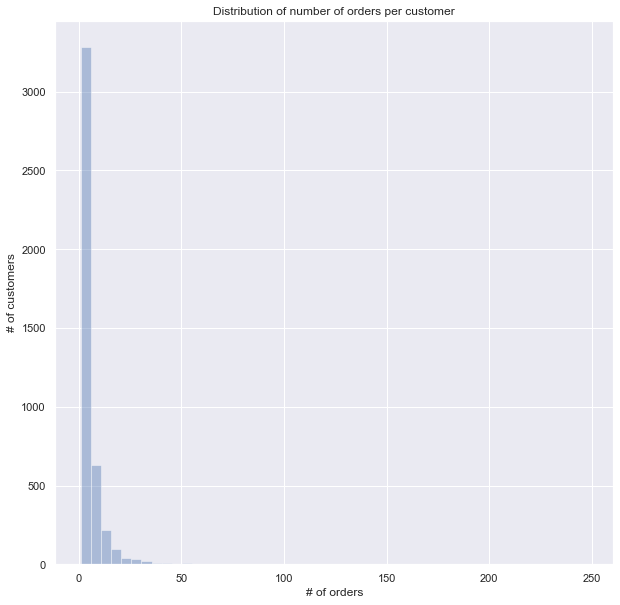

In [13]:
fig,ax = plt.subplots(figsize=(10,10))
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',xlabel='# of orders', ylabel='# of customers')

### Data Transformation:
### 2)Perform cohort analysis (a cohort is a group of subjects that share a defining characteristic). Observe how a cohort behaves across time and compare it to other cohorts.

a. Create month cohorts and analyze active customers for each cohort.

b. Analyze the retention rate of customers.

In [14]:
Online_Retail['order_month'] = Online_Retail['InvoiceDate'].dt.to_period('M')
Online_Retail['cohort'] = Online_Retail.groupby('CustomerID')['InvoiceDate'] \
                .transform('min') \
               .dt.to_period('M') 

In [15]:
df_cohort = Online_Retail.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [16]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',columns = 'period_number',values = 'n_customers')

In [17]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

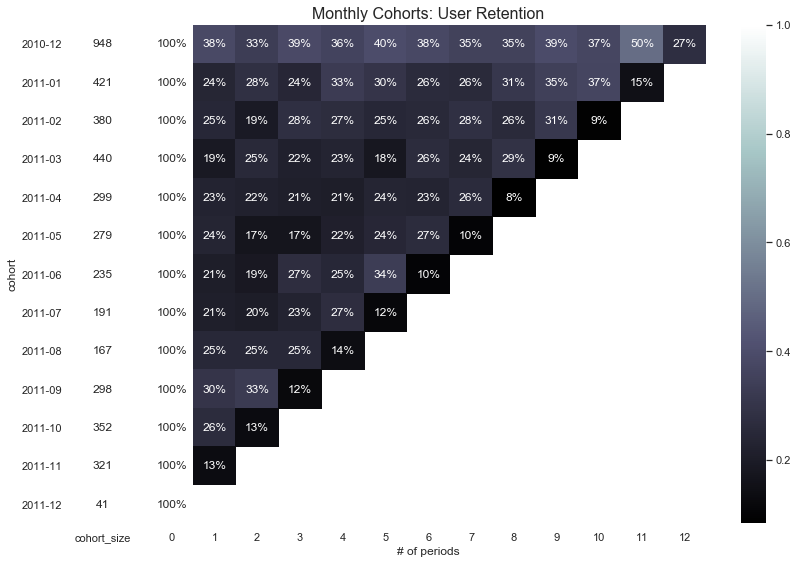

In [18]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='bone', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

## Project Task: Week 2

### Data Modeling :

### 1) Build a RFM (Recency Frequency Monetary) model. Recency means the number of days since a customer made the last purchase. Frequency is the number of purchase in a given period. It could be 3 months, 6 months or 1 year. Monetary is the total amount of money a customer spent in that given period. Therefore, big spenders will be differentiated among other customers such as MVP (Minimum Viable Product) or VIP.

### 2) Calculate RFM metrics.

### Recency

In [19]:
Online_Retail["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [20]:
today_date = dt.datetime(2011,12,9)

In [21]:
Online_Retail["CustomerID"] = Online_Retail["CustomerID"].astype(int) 

In [22]:
# Grouping the last invoice dates according to the Customer ID variable, subtracting them from today_date, and assigning them as recency
recency = (today_date - Online_Retail.groupby("CustomerID").agg({"InvoiceDate":"max"}))
# Rename column name as Recency
recency.rename(columns = {"InvoiceDate":"Recency"}, inplace = True)
# Change the values to day format
recency_df = recency["Recency"].apply(lambda x: x.days)
recency_df.head()

CustomerID
12346    324
12347      1
12348     74
12349     17
12350    309
Name: Recency, dtype: int64

### Frequency

In [23]:
# Grouping unique values of invoice date according to customer_id variable and assigning them to freq_df variable
freq_df = Online_Retail.groupby("CustomerID").agg({"InvoiceDate":"nunique"}) 
# Rename column name as Frequency
freq_df.rename(columns={"InvoiceDate": "Frequency"}, inplace=True)
freq_df.head()

,Frequency
CustomerID,
12346,2
12347,7
12348,4
12349,1
12350,1


### Monetary

In [24]:
Online_Retail.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'order_month', 'cohort'],
      dtype='object')

In [25]:
# Multiplying the prices and quantities of purchased products and assigning them to the total price variable
Online_Retail["TotalPrice"] = Online_Retail["Quantity"] * Online_Retail["UnitPrice"]

In [26]:
# Grouping and sum up total prices according to each Customer ID
monetary_df = Online_Retail.groupby("CustomerID").agg({"TotalPrice":"sum"})
#Rename Total Price column as Monetary
monetary_df.rename(columns={"TotalPrice":"Monetary"}, inplace=True)
monetary_df.head()

,Monetary
CustomerID,
12346,0.00
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40


### 3) Build RFM Segments. Give recency, frequency, and monetary scores individually by dividing them into quartiles.

b1. Combine three ratings to get a RFM segment (as strings).

b2. Get the RFM score by adding up the three ratings.

b3. Analyze the RFM segments by summarizing them and comment on the findings.

Note: Rate “recency" for customer who has been active more recently higher than the less recent customer, because each company wants its customers to be recent.

Note: Rate “frequency" and “monetary" higher, because the company wants the customer to visit more often and spend more money.

In [27]:
rfm = pd.concat([recency_df, freq_df, monetary_df],  axis=1)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,324,2,0.00
12347,1,7,4310.00
12348,74,4,1797.24
12349,17,1,1757.55
12350,309,1,334.40


In [28]:
# Dividing the recency values into recency scores such that the lowest recency value as 5 and the highest as 1
rfm["RecencyScore"] = pd.qcut(rfm["Recency"], 5, labels = [5, 4 , 3, 2, 1]) 
# Dividing the frequency values into frequency scores such that the lowest frequency value as 1 and the highest as 5
rfm["FrequencyScore"]= pd.qcut(rfm["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
# Dividing the monetary values into monetary scores such that the lowest monetary value as 1 and the highest as 5
rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])

In [29]:
# Combining Recency, Frequency, and Monetary Scores in a string format
rfm["RFM_SCORE"] = (rfm['RecencyScore'].astype(str) + 
                    rfm['FrequencyScore'].astype(str) + 
                    rfm['MonetaryScore'].astype(str))

In [30]:
# Customers with best scores
rfm[rfm["RFM_SCORE"]=="555"].head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
CustomerID,,,,,,,
12362,2,13,5154.58,5,5,5,555
12417,2,12,3578.80,5,5,5,555
12437,0,19,4896.66,5,5,5,555
12471,1,49,18740.92,5,5,5,555
12476,0,20,6546.58,5,5,5,555


In [31]:
# Customers with worst scores
rfm[rfm["RFM_SCORE"]=="111"].head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
CustomerID,,,,,,,
12353,203,1,89.00,1,1,1,111
12361,286,1,189.90,1,1,1,111
12401,302,1,84.30,1,1,1,111
12402,322,1,225.60,1,1,1,111
12441,365,1,173.55,1,1,1,111


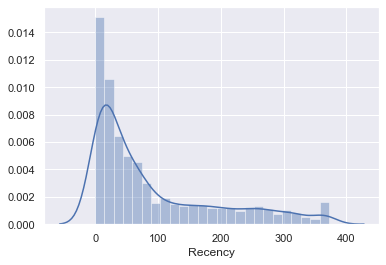

In [32]:
# Recency Distribution.
x = rfm['Recency']
ax = sns.distplot(x)

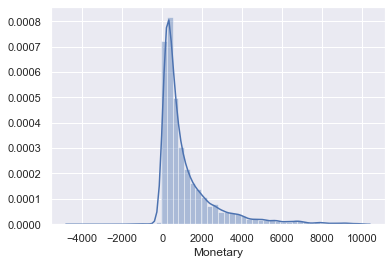

In [33]:
y = rfm.query('Monetary < 10000')['Monetary']
ax = sns.distplot(y)

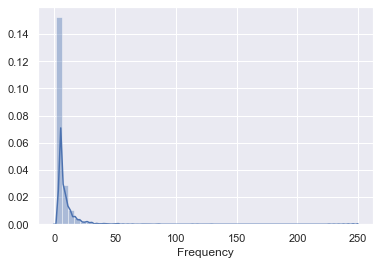

In [34]:
z = rfm.query('Frequency < 1000')['Frequency']

ax = sns.distplot(z)

## Project Task: Week 3
### Data Modeling :

## MACHINE LEARNING IMPORTS

In [35]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

### 1. Create clusters using k-means clustering algorithm.

### a. Prepare the data for the algorithm. If the data is asymmetrically distributed, manage the skewness with appropriate transformation. Standardize the data.

### b. Decide the optimum number of clusters to be formed.

### c. Analyze these clusters and comment on the results.

In [36]:
rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4372, 3)

In [37]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.231001,-0.328714,2.316568
1,0.293432,0.211970,-0.889050
2,-0.012316,-0.112440,-0.164560
3,-0.017146,-0.436851,-0.730258
4,-0.190312,-0.436851,2.167700


In [38]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [39]:
kmeans.labels_

array([2, 3, 3, ..., 3, 3, 3])

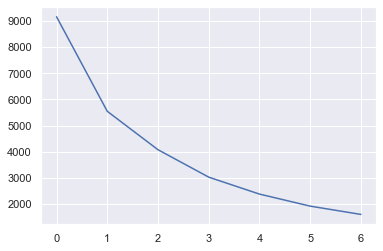

In [40]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [41]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.9046284824081512
For n_clusters=3, the silhouette score is 0.5863978241984314
For n_clusters=4, the silhouette score is 0.610646796092451
For n_clusters=5, the silhouette score is 0.614388997253775
For n_clusters=6, the silhouette score is 0.5783926979268867
For n_clusters=7, the silhouette score is 0.514214792894716
For n_clusters=8, the silhouette score is 0.49609012370421485


In [42]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [43]:
kmeans.labels_

array([0, 2, 2, ..., 2, 2, 2])

In [44]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Cluster_Id
CustomerID,,,,,,,,
12346,324,2,0.00,1,2,1,121,0
12347,1,7,4310.00,5,4,5,545,2
12348,74,4,1797.24,2,3,4,234,2
12349,17,1,1757.55,4,1,4,414,2
12350,309,1,334.40,1,1,2,112,0


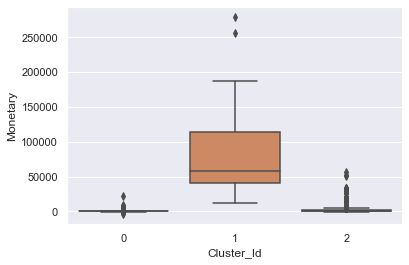

In [45]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Monetary', data=rfm)

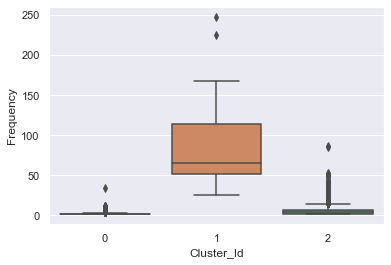

In [46]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

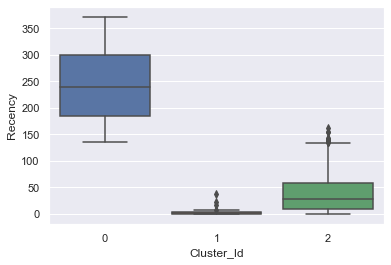

In [47]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

### Hierarchical Clustering:
1. Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,


a) Divisive
b) Agglomerative.

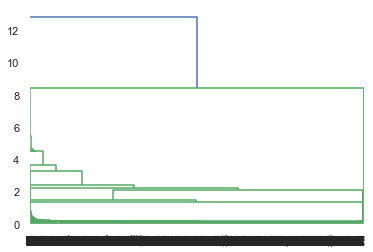

In [48]:
# Single linkage: 
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

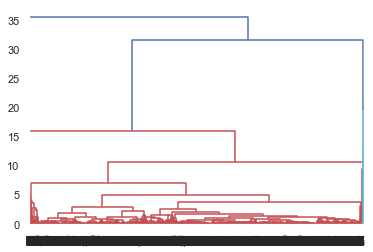

In [49]:
# Complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

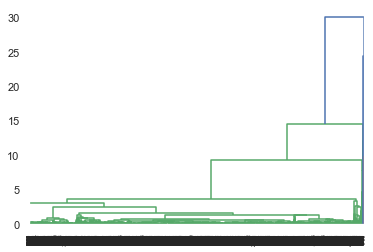

In [50]:
# Average linkage
mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

### Cutting the Dendrogram based on K

In [51]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
# Assign cluster labels
rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Cluster_Id,Cluster_Labels
CustomerID,,,,,,,,,
12346,324,2,0.00,1,2,1,121,0,0
12347,1,7,4310.00,5,4,5,545,2,0
12348,74,4,1797.24,2,3,4,234,2,0
12349,17,1,1757.55,4,1,4,414,2,0
12350,309,1,334.40,1,1,2,112,0,0


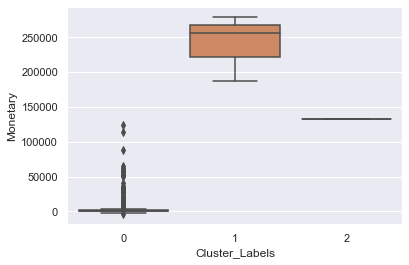

In [53]:
# Plot Cluster Id vs Amount
sns.boxplot(x='Cluster_Labels', y='Monetary', data=rfm)

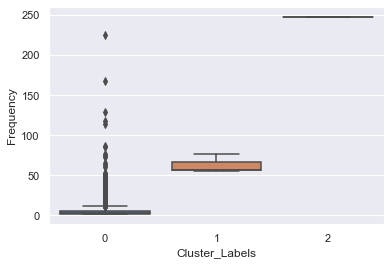

In [54]:
# Plot Cluster Id vs Frequency
sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

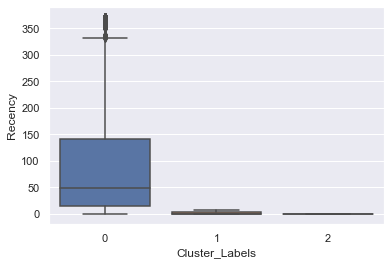

In [55]:
# Plot Cluster Id vs Recency
sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

## Inference:
## K-Means Clustering with 3 Cluster Ids

### Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
### Customers with Cluster Id 1 are frequent buyers.
### Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

## Hierarchical Clustering with 3 Cluster Labels

### Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
### Customers with Cluster_Labels 2 are frequent buyers.
### Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.

# (TABLEAU)
## Project Task: Week 4
### Data Reporting: 

### 1. Create a dashboard in tableau by choosing appropriate chart types and metrics useful for the business. The dashboard must entail the following:

a. Country-wise analysis to demonstrate average spend. Use a bar chart to show the monthly figures

b. Bar graph of top 15 products which are mostly ordered by the users to show the number of products sold

c. Bar graph to show the count of orders vs. hours throughout the day

d. Plot the distribution of RFM values using histogram and frequency charts

e. Plot error (cost) vs. number of clusters selected

f. Visualize to compare the RFM values of the clusters using heatmap

## DASHBOARD LINK (Both are same links)